# IMDB (Internet Movie Database)

## [Keras Dataset](https://keras.io/datasets/)

IMDB Movie reviews sentiment classification

- Reviews de 25.000 peliculas de IMDB
- Etiquetadas por sentimiento (Positivo/Negativo)
- Los reviews ya estan pre-procesados
- Cada review esta codificado como una secuencia de indices de palabras (integers)
- Los indices estan ordenados por frecuencia. Es decir que la palabra que tiene el índice 3 es la 3er palabra mas frecuente.
- 0 no es el indice de una palabra específica sino que se usa para codificar las palabras desconocidas

In [1]:
# Imports
import numpy as np
import keras
import pandas as pd
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling1D
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras import optimizers
from fnn_helper import PlotLosses
%matplotlib inline

np.random.seed(1337)  

Using TensorFlow backend.


In [3]:
## Embedding
max_features = 1000
max_words = 400
embedding_size = 50

# Convolution
kernel_size = 3
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 100

# Training
batch_size = 50
epochs = 20

print('Loading data...')
(X, y), (X_test, y_test) = imdb.load_data(num_words=max_features)

# 40% del dataset para validación
validation = 0.40
N_validation_split = int(X.shape[0]*(1-validation))
print(N_validation_split)

# Training Set
X_train = X[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
X_test = X[N_validation_split:]
y_test = y[N_validation_split:]

maxlen = 400
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print('Review:')
print(X_train[0])
print()
print('Sentimiento:')
print(y_train[0])


Loading data...
15000
Pad sequences (samples x time)
X_train shape: (15000, 400)
X_test shape: (10000, 400)
15000 train sequences
10000 test sequences
Review:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173
  36 256   5  25 100  43 838 112  50 6

## DEFINICION DE MODELOS 

In [11]:
#Modelos
print('Build model 1.')

def get_model(max_features, embedding_dims, maxlen, optimizer):
    model = Sequential()
    model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer == 'adam':
        optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    elif optimizer == 'rmsprop':
        optim = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    elif optimizer == 'sgd':
        optim = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    print(model.summary())
    return model

Build model 1.


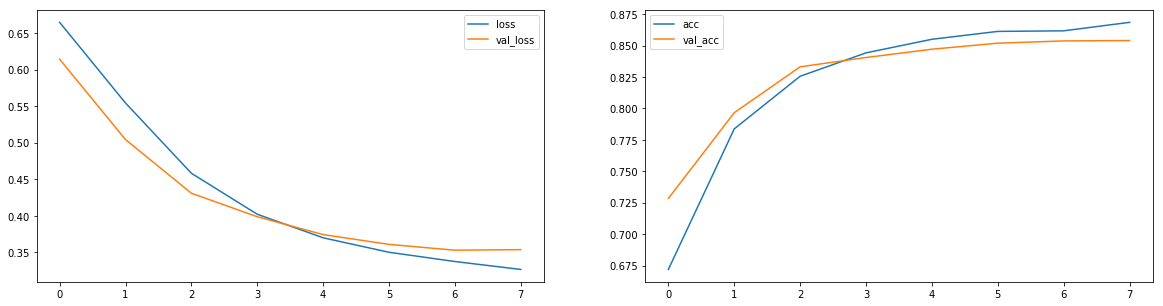

Epoch 00007: val_loss did not improve
15000/15000 [==============================] - 19s - loss: 0.3265 - acc: 0.8685 - val_loss: 0.3537 - val_acc: 0.8540


In [12]:
#Entrenar el modelo 
from fnn_helper import PlotLosses
from keras.callbacks import ModelCheckpoint 

## Callback para graficar
plot_losses1 = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
## Callback para guardar pesos
checkpointer1= ModelCheckpoint(filepath='model1_adam.imdb.hdf5', verbose=1, save_best_only=True)

# Use different optimization methods
opt = "adam"
model1 = get_model(max_features=20000, embedding_dims=50, maxlen=maxlen, optimizer=opt)
model1.fit(X_train, y_train, batch_size=32, epochs=8, 
        validation_data=(X_test, y_test), callbacks=[plot_losses1,checkpointer1])

In [53]:
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 400, 50)           1000000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 1,000,051
Trainable params: 1,000,051
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
score = model1.evaluate(X_test, y_test, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.353658393574
accuracy:  0.854


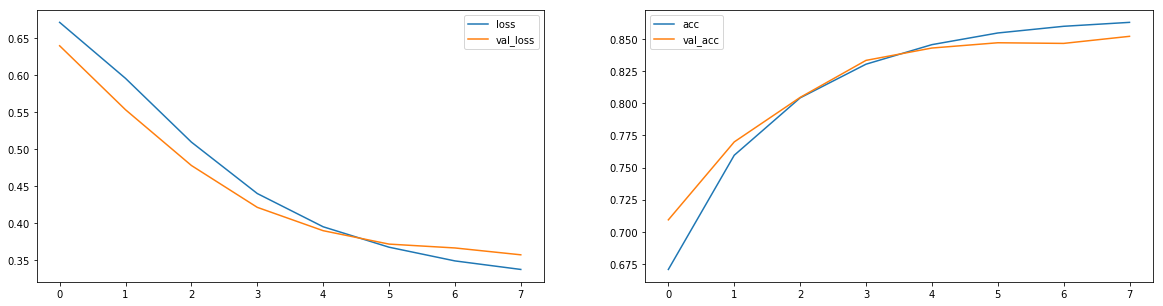

Epoch 00007: val_loss improved from 0.36666 to 0.35740, saving model to model2_rmsprop.imdb.hdf5
15000/15000 [==============================] - 18s - loss: 0.3376 - acc: 0.8629 - val_loss: 0.3574 - val_acc: 0.8520


In [16]:
## Callback para graficar
plot_losses2 = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
## Callback para guardar pesos
checkpointer2= ModelCheckpoint(filepath='model2_rmsprop.imdb.hdf5', verbose=1, save_best_only=True)

opt = 'rmsprop'
model2 = get_model(max_features=20000, embedding_dims=50, maxlen=maxlen, optimizer=opt)
model2.fit(X_train, y_train, batch_size=32, epochs=8, 
        validation_data=(X_test, y_test), callbacks=[plot_losses2,checkpointer2])

In [54]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 400, 50)           1000000   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 1,000,051
Trainable params: 1,000,051
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
score = model2.evaluate(X_test, y_test, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.357396366024
accuracy:  0.852


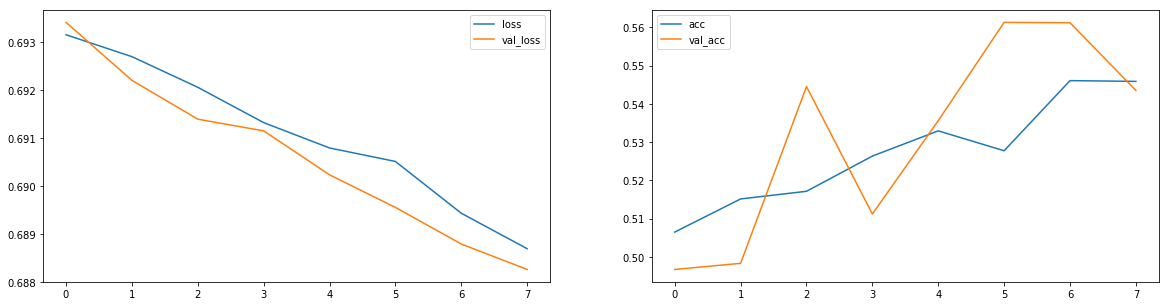

Epoch 00007: val_loss improved from 0.68879 to 0.68826, saving model to model3_sgd.imdb.hdf5
15000/15000 [==============================] - 13s - loss: 0.6887 - acc: 0.5459 - val_loss: 0.6883 - val_acc: 0.5435


In [18]:
## Callback para graficar
plot_losses3 = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
## Callback para guardar pesos
checkpointer3= ModelCheckpoint(filepath='model3_sgd.imdb.hdf5', verbose=1, save_best_only=True)

opt = 'sgd'
model3 = get_model(max_features=20000, embedding_dims=50, maxlen=maxlen, optimizer=opt)
model3.fit(X_train, y_train, batch_size=32, epochs=8, 
        validation_data=(X_test, y_test), callbacks=[plot_losses3,checkpointer3])

In [55]:
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 400, 50)           1000000   
_________________________________________________________________
global_average_pooling1d_7 ( (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 1,000,051
Trainable params: 1,000,051
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
score = model3.evaluate(X_test, y_test, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.688260947227
accuracy:  0.5435


In [22]:
#Analisis de los pesos
weights = model1.get_weights()[0]
biases = model1.get_weights()[1]
print(weights.shape)
print(biases)

(20000, 50)
[[-2.43954158]
 [-1.96259332]
 [ 2.97817969]
 [ 2.4319911 ]
 [-1.91594422]
 [ 2.23950958]
 [ 2.25093818]
 [ 2.46685505]
 [ 2.28642249]
 [ 1.8175211 ]
 [ 1.98199439]
 [ 2.16878295]
 [ 2.74310875]
 [-2.41972232]
 [-2.35081172]
 [-2.34717703]
 [ 2.7196033 ]
 [ 2.36131024]
 [-2.78513217]
 [ 2.77013707]
 [ 2.06413412]
 [ 2.7566824 ]
 [-2.73409772]
 [ 2.36229777]
 [ 2.08426428]
 [ 2.45036936]
 [-2.08217764]
 [-1.97219872]
 [ 2.35267472]
 [ 2.30106115]
 [-2.66191292]
 [-2.72326589]
 [ 1.79278636]
 [ 2.7854507 ]
 [ 2.53654575]
 [-2.8631537 ]
 [ 2.5720427 ]
 [ 2.18132925]
 [-2.70358133]
 [ 2.21839142]
 [-2.59229016]
 [ 2.74647474]
 [ 2.75951266]
 [-2.15025258]
 [-2.48726535]
 [-1.90528584]
 [-2.10672283]
 [-1.94188547]
 [-2.63237596]
 [-2.42590022]]


In [25]:
# Cargo los valores del modelo
model1.load_weights('model1_adam.imdb.hdf5')
score1 = model1.evaluate(X_test, y_test, verbose=0)
print("loss: ", score1[0])
print("accuracy: ", score1[1])

loss:  0.352898679805
accuracy:  0.8537


In [28]:
# Cargo los valores del modelo
model2.load_weights('model2_rmsprop.imdb.hdf5')
score2= model2.evaluate(X_test, y_test, verbose=0)
print("loss: ", score2[0])
print("accuracy: ", score2[1])

loss:  0.357396366024
accuracy:  0.852


In [30]:
# Cargo los valores del modelo
model3.load_weights('model3_sgd.imdb.hdf5')
score3 = model3.evaluate(X_test, y_test, verbose=0)
print("loss: ", score3[0])
print("accuracy: ", score3[1])

loss:  0.688260947227
accuracy:  0.5435


In [45]:
#Modelo 4
print('Build model 4.')
max_features=20000
model4 = Sequential()
model4.add(Embedding(max_features,embedding_size,input_length=max_words))
model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(LSTM(100 , dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Build model 4.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 400, 50)           1000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 400, 32)           4832      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 1,058,133
Trainable params: 1,058,133
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
from keras.callbacks import ModelCheckpoint 
#Callbacks
## Callback para graficar
plot_losses4 = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
## Callback para guardar pesos
checkpointer4 = ModelCheckpoint(filepath='model4_dropout.imdb.hdf5', verbose=1, save_best_only=True)

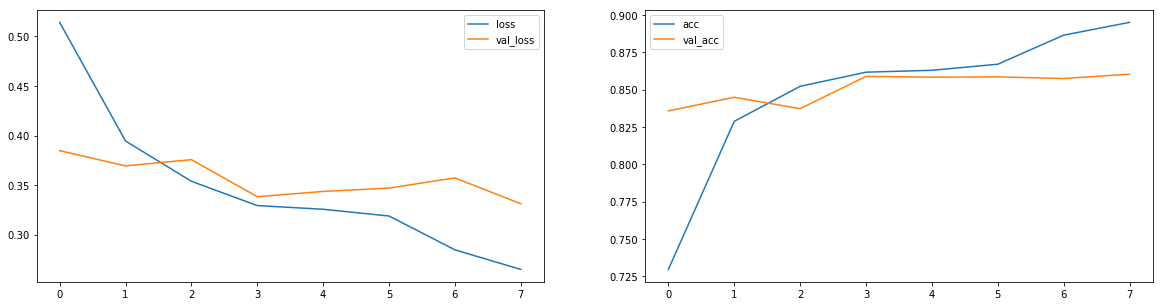

Epoch 00007: val_loss improved from 0.33835 to 0.33123, saving model to model4_dropout.imdb.hdf5
15000/15000 [==============================] - 196s - loss: 0.2650 - acc: 0.8951 - val_loss: 0.3312 - val_acc: 0.8604
Accuracy:  0.8604


In [47]:
#Entrenar el modelo 
epochs=8
batch_size=32
model4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
          validation_data=(X_test, y_test), callbacks=[plot_losses4, checkpointer4])

score4 = model4.evaluate(X_test, y_test, verbose=2)
print("Accuracy: " , score4[1])

In [48]:
#Analisis de los pesos
weights = model4.get_weights()[0]
biases = model4.get_weights()[1]
print(weights.shape)
print(biases)

(20000, 50)
[[[ 0.25666636  0.29246402  0.18562739 ..., -0.03681877  0.03504189
    0.07185462]
  [ 0.14531502 -0.18966128 -0.2649895  ..., -0.00941864 -0.30044845
   -0.2189562 ]
  [ 0.25640279  0.2290599  -0.134709   ...,  0.15744181  0.13968356
   -0.11213198]
  ..., 
  [-0.17960675 -0.17294167  0.06065945 ..., -0.0782686  -0.08718974
   -0.12997536]
  [-0.04431591  0.00371567 -0.20129603 ...,  0.06891564  0.0852187
   -0.12544687]
  [-0.01231497  0.1405073  -0.04683115 ..., -0.13737266 -0.42868596
   -0.12789609]]

 [[-0.16965882 -0.2368515   0.10105663 ...,  0.1388858   0.1484486
    0.25167677]
  [ 0.12314547  0.339616    0.11918573 ...,  0.05189869 -0.0619068
   -0.02183547]
  [-0.0674835  -0.00246635  0.09280814 ...,  0.01060124  0.05222907
   -0.05561339]
  ..., 
  [-0.1606897  -0.14854994 -0.07516189 ..., -0.14696546 -0.01179247
   -0.01572628]
  [-0.0568232  -0.24586646  0.0257655  ..., -0.17659543 -0.31486544
   -0.0517349 ]
  [-0.12261675 -0.05204658  0.06333318 ..., -0.20

In [51]:
# Cargo los valores del modelo
model4.load_weights('model4_dropout.imdb.hdf5')
score4 = model4.evaluate(X_test, y_test, verbose=0)
print("loss: ", score4[0])
print("accuracy: ", score4[1])

loss:  0.33122740624
accuracy:  0.8604


Ejemplo:
<img src="images/training_IMDB.png" alt="Drawing" style="width:100%;"/>